<a href="https://colab.research.google.com/github/lebe1/ClimateChangeAI/blob/main/Multi-time-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

/home/funny/.virtualenvs/climateChangeAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1 - Modeling

In [2]:
# Import data
df_train = pd.read_csv('scaled_train.csv', sep=';')
df_test = pd.read_csv('scaled_test.csv', sep=';')

In [3]:
df_train.head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
0,1981,1,1,1,-0.848457,-0.648853,-0.465513,-0.609571,-0.556990,-0.549324,...,-0.646738,-0.380941,0.668398,-0.602772,1.202823,0.725221,0.259473,-0.370788,0.564634,0.874327
1,1981,1,2,2,-1.036223,-0.788476,-0.525469,-0.597103,-0.629726,-0.629324,...,-0.572827,-0.877310,0.679110,-0.852623,3.424653,0.725221,0.259473,-0.370788,0.564634,0.874327
2,1981,1,3,3,-0.638602,-0.381243,-0.093786,-0.272918,-0.120574,0.033530,...,-2.494519,-1.824924,0.477628,-1.155472,0.262555,0.725221,0.259473,-0.370788,0.564634,0.874327
3,1981,1,4,4,-0.892638,-0.602312,-0.321619,-0.435011,-0.363027,-0.229326,...,-0.905427,-0.651688,0.435725,-0.837481,0.129450,1.125163,0.259473,-0.370788,0.564634,0.874327
4,1981,1,5,5,-1.257123,-1.044451,-0.729319,-0.971161,-1.017651,-0.880751,...,0.203242,-0.110194,0.540641,-0.746626,0.127744,0.925192,0.259473,-0.370788,0.564634,0.874327


In [4]:
# Create new index based on date columns YYYY-MM
df_train['date'] = pd.to_datetime(dict(year=df_train['YYYY'], month=df_train['MM'], day=df_train['DD']))

# Set date as index
df_train.set_index('date', inplace=True)

# Drop columns
df_train.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

df_train.head()

,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,1,-0.848457,-0.648853,-0.465513,-0.609571,-0.556990,-0.549324,4.117408,-0.214419,0.011780,...,-0.646738,-0.380941,0.668398,-0.602772,1.202823,0.725221,0.259473,-0.370788,0.564634,0.874327
1981-01-02,2,-1.036223,-0.788476,-0.525469,-0.597103,-0.629726,-0.629324,3.384517,-0.116169,0.393698,...,-0.572827,-0.877310,0.679110,-0.852623,3.424653,0.725221,0.259473,-0.370788,0.564634,0.874327
1981-01-03,3,-0.638602,-0.381243,-0.093786,-0.272918,-0.120574,0.033530,4.557143,0.964587,0.521004,...,-2.494519,-1.824924,0.477628,-1.155472,0.262555,0.725221,0.259473,-0.370788,0.564634,0.874327
1981-01-04,4,-0.892638,-0.602312,-0.321619,-0.435011,-0.363027,-0.229326,3.164649,0.080332,0.521004,...,-0.905427,-0.651688,0.435725,-0.837481,0.129450,1.125163,0.259473,-0.370788,0.564634,0.874327
1981-01-05,5,-1.257123,-1.044451,-0.729319,-0.971161,-1.017651,-0.880751,2.798204,-1.884678,0.521004,...,0.203242,-0.110194,0.540641,-0.746626,0.127744,0.925192,0.259473,-0.370788,0.564634,0.874327


In [5]:
# Same for test data
df_test['date'] = pd.to_datetime(dict(year=df_test['YYYY'], month=df_test['MM'], day=df_test['DD']))
df_test.set_index('date', inplace=True)
df_test.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

In [6]:
df_list = []

# Get dataframes from directory
for i in range(0, 100):
    df = pd.read_csv('./df_list/df_' + str(i) + '.csv', sep=';')
    df_list.append(df)

In [7]:
df_list[0].head()

,Unnamed: 0,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
0,0,1981,1,1,1,-1.377672,-1.481037,-1.521961,-1.336550,-1.451005,...,-0.064722,-0.154222,-0.662001,-0.992769,-0.235582,-1.047199,0.280296,0.0,0.0,0.0
1,1,1981,1,2,2,-1.701406,-1.597696,-1.403849,-1.631321,-1.579055,...,-0.793984,-0.055528,-0.618570,-1.000963,0.139242,-1.047199,0.280296,0.0,0.0,0.0
2,2,1981,1,3,3,-1.340318,-1.208832,-1.154501,-1.041779,-1.002831,...,-0.218251,-0.943774,-1.750661,-1.148451,0.104332,-1.047199,0.280296,0.0,0.0,0.0
3,3,1981,1,4,4,-1.228256,-1.144021,-1.049512,-0.988184,-0.951611,...,-0.333398,-0.252916,-2.551232,-1.074707,-0.079405,-1.047199,0.280296,0.0,0.0,0.0
4,4,1981,1,5,5,-1.987786,-1.779166,-1.521961,-1.952890,-1.937595,...,0.012042,0.339249,-2.086524,-0.796118,0.447921,-1.047199,0.280296,0.0,0.0,0.0


In [8]:
for index, df in enumerate(df_list):
   # Create new index based on date columns YYYY-MM
    df['date'] = pd.to_datetime(dict(year=df['YYYY'], month=df['MM'], day=df['DD']))

    # Set date as index
    df.set_index('date', inplace=True)

    df = df.asfreq('D')

    # Drop columns
    df.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

    df_list[index] = df

print(df_list[0].index.freq)
# df_list[0].head()

<Day>


In [9]:
df_prec = pd.DataFrame()
# Iterate over df_list
for index, df in enumerate(df_list):
    # For each dataframe, create a new prec column
    df_prec['prec_' + str(index)] = df['prec']

df_prec.head()

,prec_0,prec_1,prec_2,prec_3,prec_4,prec_5,prec_6,prec_7,prec_8,prec_9,...,prec_90,prec_91,prec_92,prec_93,prec_94,prec_95,prec_96,prec_97,prec_98,prec_99
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,-0.235582,0.438799,0.068684,0.550716,0.054181,0.273805,0.299977,0.207383,0.114982,0.147843,...,0.492858,0.531730,0.638913,0.916671,-0.349451,0.741276,0.480610,-0.160143,0.991481,0.154770
1981-01-02,0.139242,1.944135,0.842428,1.564660,0.639620,1.244781,1.359009,0.919955,2.186035,1.187061,...,1.499125,1.473379,1.548220,0.845212,0.209641,1.668634,1.198331,0.073036,1.864271,0.304025
1981-01-03,0.104332,2.392353,1.170955,1.996053,0.425588,1.328545,2.799883,3.600271,2.343978,1.818014,...,1.772392,1.932218,0.913658,1.821236,0.019077,1.663603,0.703204,1.785896,2.075547,2.097805
1981-01-04,-0.079405,0.574110,2.713057,0.649223,0.324868,3.034591,0.584777,0.057024,0.395275,2.959298,...,0.676108,1.125825,1.716972,0.566348,0.163968,0.967666,2.690849,-0.258021,1.253755,0.078785
1981-01-05,0.447921,0.041323,1.470758,0.739239,1.489451,1.894378,0.207154,0.342489,0.072716,1.773476,...,0.732369,1.713071,1.984743,1.066560,0.748259,2.116381,1.750534,0.133490,1.670479,0.287743


In [10]:
# Split in train and test
# ==============================================================================

line_for_70pct = round(len(df_prec) * 0.7)

data_train = df_prec.iloc[:line_for_70pct, :]
data_test  = df_prec.iloc[line_for_70pct:, :]


print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1981-01-01 00:00:00 --- 2008-04-19 00:00:00   (n=9971)
Test dates  : 2008-04-20 00:00:00 --- 2019-12-31 00:00:00   (n=4273)


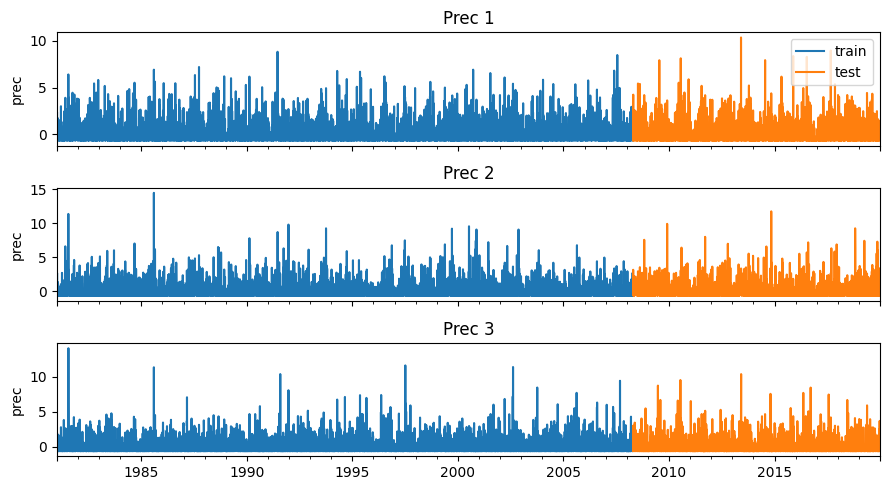

In [11]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['prec_1'].plot(label='train', ax=axes[0])
data_test['prec_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('prec')
axes[0].set_title('Prec 1')
axes[0].legend()

data_train['prec_2'].plot(label='train', ax=axes[1])
data_test['prec_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('prec')
axes[1].set_title('Prec 2')

data_train['prec_3'].plot(label='train', ax=axes[2])
data_test['prec_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('prec')
axes[2].set_title('Prec 3')

fig.tight_layout()
plt.show()

In [12]:
#from xgboost import XGBRegressor
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train, exog=None)
forecaster

ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['prec_0', 'prec_1', 'prec_2', 'prec_3', 'prec_4', 'prec_5', 'prec_6', 'prec_7', 'prec_8', 'prec_9', 'prec_10', 'prec_11', 'prec_12', 'prec_13', 'prec_14', 'prec_15', 'prec_16', 'prec_17', 'prec_18', 'prec_19', 'prec_20', 'prec_21', 'prec_22', 'prec_23', 'prec_24', 'prec_25', 'prec_26', 'prec_27', 'prec_28', 'prec_29', 'prec_30', 'prec_31', 'prec_32', 'prec_33', 'prec_34', 'prec_35', 'prec_36', 'prec_37', 'prec_38', 'prec_39', 'prec_40', 'prec_41', 'prec_42', 'prec_43', 'prec_44', 'prec_45', 'prec_46', 'prec_47', 'prec_48', 'prec_49', 'prec_50', 'prec_51', 'prec_52', 'prec_53', 'prec_54', 'prec_55', 'prec_56', 'prec_57', 'prec_58', 'prec_59', 'prec_60', 'prec_61', 'prec_62', 'prec_63', 'prec_64', 'prec_65', 'prec_66', 'prec_67', 'prec_68', 'prec

In [13]:
# Predict and predict_interval
# ==============================================================================
steps = 1

## Predictions
predictions_prec_all = forecaster.predict(steps=steps)
display(predictions_prec_all.head())
print(predictions_prec_all.shape)


,prec_0,prec_1,prec_2,prec_3,prec_4,prec_5,prec_6,prec_7,prec_8,prec_9,...,prec_90,prec_91,prec_92,prec_93,prec_94,prec_95,prec_96,prec_97,prec_98,prec_99
2008-04-20,0.068786,0.054954,0.086028,-0.066428,0.111002,0.121997,-0.134197,-0.043569,0.196545,-0.000964,...,-0.015833,0.026385,0.101058,-0.13024,0.011805,0.081157,-0.012561,0.462686,-0.038614,0.200925


(1, 100)


In [14]:
# The root mean squared error (RMSE), parameter squared=False gives the RMSE
print("Root mean squared error: %.2f"
      % mean_squared_error(data_test[:1], predictions_prec_all, squared=False))

Root mean squared error: 0.69


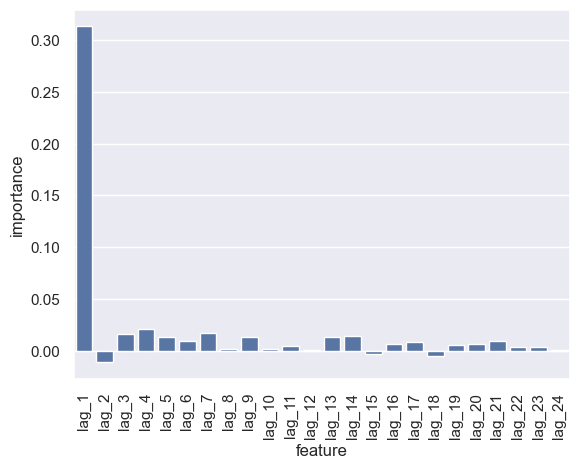

In [15]:
feature_importance = forecaster.get_feature_importances()

# Plot feature importance by using only lags

lags = feature_importance[:24]

# plt.bar(x=lags['feature'], height=lags['importance'])
sns.set_theme()
sns.barplot(x=lags['feature'], y=lags['importance'])
# Set x labels vertically
plt.xticks(rotation=90)
plt.show()

# Export analysing data

In [16]:
# Create empty dataframe
df = pd.DataFrame()

# Create rmse column
df['rmse'] = np.nan

# Add root mean squared error
df.loc[0] = mean_squared_error(data_test[:1], predictions_prec_all, squared=False)

df.head()


,rmse
0,0.690048


### Export to csv file

In [17]:
df.to_csv('time_series_model_feature_importance.csv', sep=';', index=False)